# PCS956 Project - Diabetes Health Indicators: Exploring Causality for Efficient ML and Explainability

## Overview
This project explores the role of causal understanding in machine learning models using the **CDC Diabetes Health Indicators dataset**. The primary objective is to evaluate how integrating causal knowledge impacts model performance and interpretability. We will:
- Construct a **Directed Acyclic Graph (DAG)** to represent potential causal relationships within the dataset.
- Train baseline machine learning models and compare them to models that leverage causal structures.
- Use explainability tools to analyze model predictions, emphasizing the influence of causal features.

## Dataset Description
### Source and Context
The CDC Diabetes Health Indicators dataset provides healthcare statistics and lifestyle survey information for individuals, including their diabetes diagnosis. This dataset is designed to explore the relationships between various health indicators and the likelihood of diabetes or prediabetes.

### Characteristics
- **Type**: Tabular, Multivariate
- **Subject Area**: Health and Medicine
- **Associated Tasks**: Classification
- **Feature Types**: Categorical, Integer
- **Number of Instances**: 253,680
- **Number of Features**: 21
- **Missing Values**: No

### Data Structure and Variables
The dataset includes 21 variables:
- **Diabetes_binary**: Target variable indicating diabetes status (0 = no diabetes, 1 = prediabetes or diabetes).
- **Features**:
  - **HighBP**: High blood pressure (0 = no, 1 = yes).
  - **HighChol**: High cholesterol (0 = no, 1 = yes).
  - **CholCheck**: Cholesterol check in the past 5 years (0 = no, 1 = yes).
  - **BMI**: Body Mass Index (integer value).
  - **Smoker**: Smoked at least 100 cigarettes in lifetime (0 = no, 1 = yes).
  - **Stroke**: History of stroke (0 = no, 1 = yes).
  - **HeartDiseaseorAttack**: Coronary heart disease or myocardial infarction (0 = no, 1 = yes).
  - **PhysActivity**: Physical activity in the past 30 days, excluding job-related (0 = no, 1 = yes).
  - **Income**: Categorical income levels.
  - **Education**: Categorical education levels.
  - **Additional features**: Demographics (e.g., age, sex), mental health indicators, etc.

### Project Steps
1. **Data Import and Preprocessing**:
   - Load the dataset and prepare it for analysis.
   - Check data consistency and handle any preprocessing requirements.

2. **DAG Construction and Validation**:
   - Build an initial DAG using domain expertise and statistical insights.
   - Validate the DAG through iterative pruning and edge addition to ensure acyclic structure.

3. **Model Development**:
   - Develop baseline models (e.g., Logistic Regression, Random Forest).
   - Train a causally-informed model using selected variables from the DAG.

4. **Explainability Analysis**:
   - Integrate SHAP or LIME to assess feature importance and model predictions.
   - Focus on how causal features contribute to explainability.

5. **Conclusion**:
   - Summarize the impact of causal integration on model performance and interpretability.
   - Discuss future directions for refining causal approaches in ML.

## Additional Information
The CDC created this dataset to understand the relationship between lifestyle factors and diabetes prevalence in the U.S. It includes sensitive data like gender, income, and education level, and it has been preprocessed to include no missing values. Further details can be found at the CDC's [dataset page](https://www.cdc.gov/brfss/annual_data/annual_2014.html).

# **Data Import and Preprocessing**:


In [1]:
import pandas as pd
from scipy.stats import spearmanr
from pgmpy.models import BayesianNetwork
import networkx as nx
import matplotlib.pyplot as plt
from preprocessing.dag_validation import run_dag_validation_tests

# Load the data as per the instructions provided
from ucimlrepo import fetch_ucirepo
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# Add the target variable 'Diabetes_binary' to the dataset for correlation analysis
X = X.assign(Diabetes_binary=y)

# Calculate the Spearman correlation matrix for the dataset
correlation_matrix = X.corr(method='spearman')

/mnt/RAID/projects/PCS956-Project/PCS956/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Checking for Duplicates

When training machine learning models, particularly algorithms like logistic regression and generalized linear models (GLMs), it is crucial to ensure that the dataset does not contain duplicate entries. While logistic regression and GLMs do not strictly require observations to be **identically distributed**, they do assume **independence of observations**. This means that each observation should not influence or provide information about another. Duplicate observations can lead to biased model training, overfitting, or misinterpretations of feature importance, ultimately impacting the validity of the model's conclusions.

**Investigation of Duplicates and Temporal Dependencies:**  
Our diabetes dataset, containing health indicators, may have temporal elements or repeated measurements. It is essential to investigate whether duplicates represent legitimate repeated observations, such as those from longitudinal studies, or are errors. If these duplicates are associated with a time series structure, it indicates potential temporal dependencies. These dependencies must be understood and properly handled to avoid violating the independence assumption critical for reliable model performance and interpretation.

By searching for duplicates and examining their nature, we can identify potential issues related to the independence assumption and determine if our dataset has temporal patterns that need special handling. This ensures that the data meets the requirements for valid and unbiased model training.

In [2]:
# Extract the IDs
ids = cdc_diabetes_health_indicators.data.ids

# Check for duplicate IDs
duplicate_ids = ids.duplicated(keep=False)  # Find duplicated IDs, keeping all instances of duplicates
duplicates_df = ids[duplicate_ids]

# Display the number of duplicate entries and a sample of the duplicated IDs
print(f"Number of duplicate entries found: {duplicates_df.shape[0]}")
print("Sample of duplicate entries:")
print(duplicates_df.head())

# Display unique counts for the duplicated IDs
unique_counts = duplicates_df.value_counts()
print("ID counts in duplicate entries:")
print(unique_counts)

Number of duplicate entries found: 0
Sample of duplicate entries:
Empty DataFrame
Columns: [ID]
Index: []
ID counts in duplicate entries:
Series([], Name: count, dtype: int64)


# **DAG Construction and Validation**

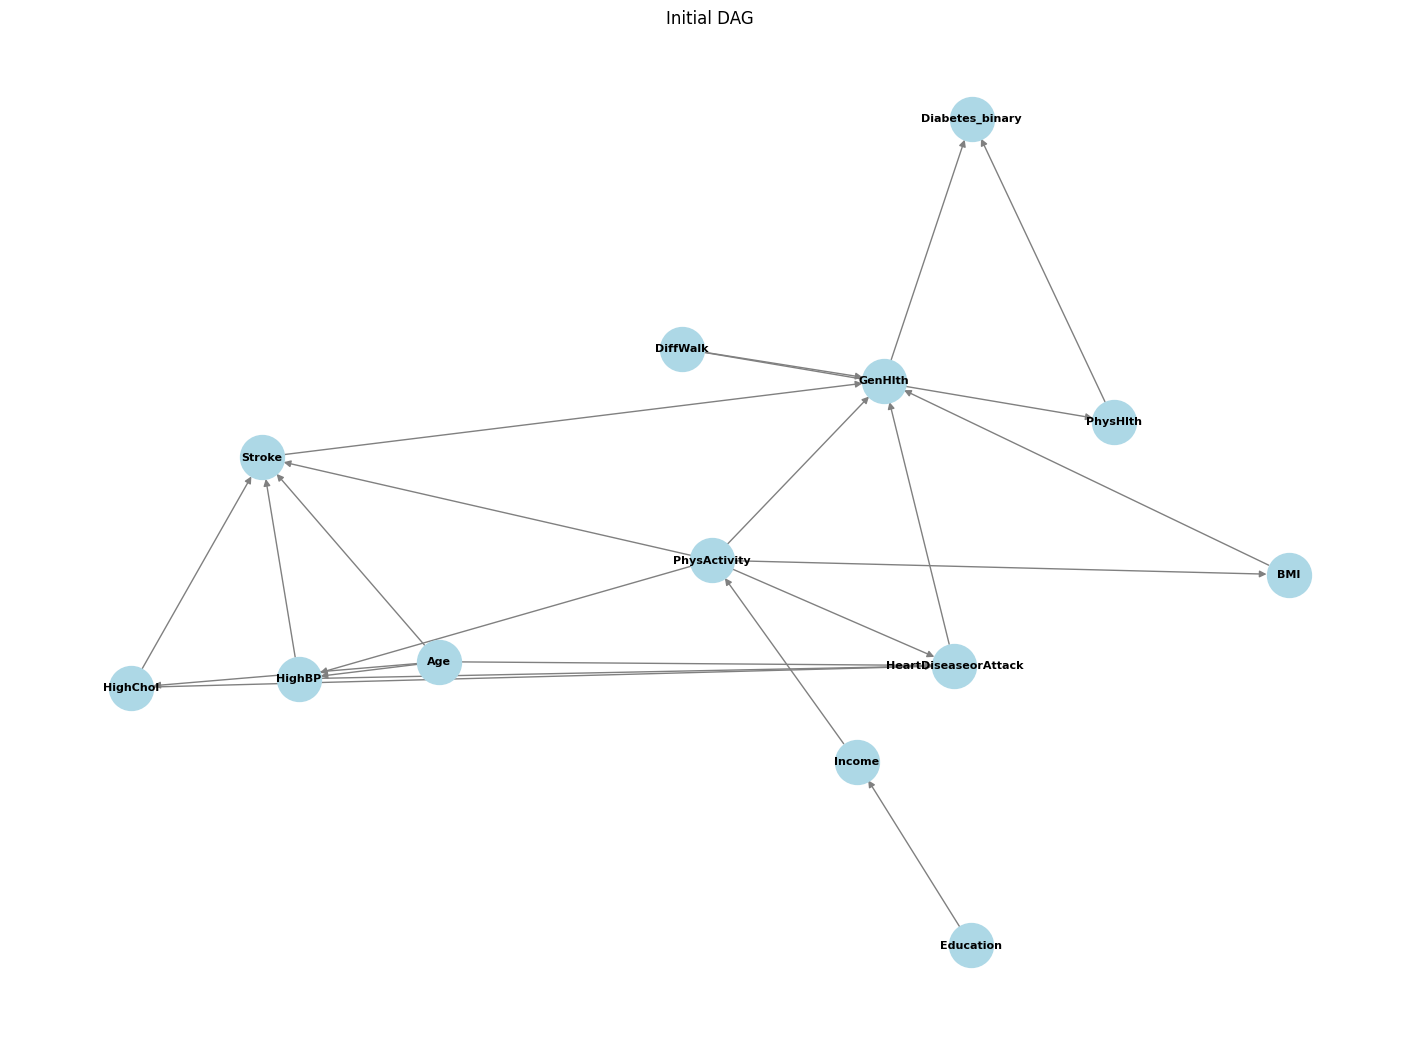

In [3]:
# Define the initial DAG structure with main feature categories
dag_structure = [
    ('Age', 'HighBP'),
    ('Age', 'HighChol'),
    ('Age', 'HeartDiseaseorAttack'),
    ('Age', 'Stroke'),
    ('Education', 'Income'),
    ('Income', 'PhysActivity'),
    ('PhysActivity', 'BMI'),
    ('PhysActivity', 'GenHlth'),
    ('HighBP', 'HeartDiseaseorAttack'),
    ('HighBP', 'Stroke'),
    ('HighChol', 'HeartDiseaseorAttack'),
    ('HighChol', 'Stroke'),
    ('BMI', 'GenHlth'),
    ('HeartDiseaseorAttack', 'GenHlth'),
    ('Stroke', 'GenHlth'),
    ('GenHlth', 'Diabetes_binary'),
    ('DiffWalk', 'GenHlth'),
    ('DiffWalk', 'PhysHlth'),
    ('PhysActivity', 'HighBP'),
    ('PhysActivity', 'Stroke'),
    ('PhysActivity', 'HeartDiseaseorAttack'),
    ('PhysHlth', 'Diabetes_binary')
]

# Create a Bayesian Network model with the filtered structure
model = BayesianNetwork(dag_structure)

# Convert the structure to a NetworkX graph for visualization
dag_graph = nx.DiGraph()
dag_graph.add_edges_from(dag_structure)

# Visualize the DAG
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(dag_graph)
nx.draw(dag_graph, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=8, font_weight='bold', edge_color='gray')
plt.title(f'Initial DAG')
plt.show()

# **DAG Construction and Validation**

## Overview of the Algorithm
To build and validate a Directed Acyclic Graph (DAG) for analyzing potential causal relationships in the dataset, we follow a systematic approach. The algorithm starts with an initial DAG structure, prunes weak or invalid connections based on correlation thresholds, validates causal relationships and conditional independences, and iteratively updates the DAG while ensuring it remains acyclic.

### Algorithm Steps
Below is the algorithm for constructing and validating the DAG:

1. **Define the Initial DAG**: Start with a domain-knowledge-based DAG structure representing hypothesized causal relationships.
2. **Filter Edges by Correlation**: Retain only the edges where the correlation between the variables meets a minimum threshold (e.g., 0.1).
3. **Validate Cause-Effect Relationships**:
   - For each edge, test the relationship using statistical methods (e.g., chi-squared for categorical data, Spearman's correlation for continuous data).
4. **Check Conditional Independences**:
   - Identify sets of variables and test conditional independences using residual analysis and significance tests.
5. **Iteratively Build and Prune the DAG**:
   - Prune edges with weak statistical support.
   - Add new significant edges based on conditional independences while ensuring the DAG remains acyclic.
6. **Repeat Until Convergence**:
   - Stop when no changes occur in the DAG structure.

In [4]:
# Run the DAG validation tests
results, conditional_results = run_dag_validation_tests(X, y, dag_structure)

# Format results into a DataFrame for presentation
formatted_results = []

for (cause, effect), metrics in results.items():
    entry = {
        'Cause': cause,
        'Effect': effect,
        'Type': metrics['type'],
        'p-value': metrics['p_value'],
        'Stat Value': metrics['test_stat'],  # Include the test statistic
    }
    formatted_results.append(entry)

df_results = pd.DataFrame(formatted_results)
df_results.to_csv('causal.csv', index=False)

Testing direct dependencies: 100%|██████████| 22/22 [00:01<00:00, 17.17it/s]


## Testing if conditional-independences are valid

In [5]:
# Prepare the data for DataFrame
formatted_conditional_results = []

for (var_X, var_Y, var_Z), metrics in conditional_results.items():
    formatted_conditional_results.append({
        'X': var_X,
        'Y': var_Y,
        'Conditioning Variable (Z)': var_Z,
        'Type': metrics['type'],
        'Test Statistic': metrics['test_statistic'],
        'p-value': metrics['p_value']
    })

# Create DataFrame
df_conditional_results = pd.DataFrame(formatted_conditional_results)

# Optionally, sort the DataFrame by p-value for easier review
df_conditional_results.sort_values(by='p-value', inplace=True)
df_conditional_results.to_csv('conditional.csv', index=False)

## Find Significant dependencies

In [6]:
significant_dependencies = df_conditional_results[df_conditional_results['p-value'] < 0.05]
significant_dependencies

,X,Y,Conditioning Variable (Z),Type,Test Statistic,p-value
0,Age,PhysActivity,HighBP,binary-numeric,5123.196532,0.000000e+00
1,PhysActivity,Age,HighBP,binary-numeric,5123.196532,0.000000e+00
2,Age,HighChol,HighBP,binary-numeric,110330.166146,0.000000e+00
3,Age,HeartDiseaseorAttack,HighBP,binary-numeric,19271.862035,0.000000e+00
4,Age,Stroke,HighBP,binary-numeric,6786.593273,0.000000e+00
...,...,...,...,...,...,...
7,PhysActivity,Stroke,HighBP,binary-numeric,1212.260470,1.320590e-265
29,PhysActivity,Stroke,HeartDiseaseorAttack,binary-numeric,1212.260470,1.320590e-265
50,PhysActivity,Stroke,BMI,binary-numeric,1187.824131,1.167528e-258
22,HighChol,PhysActivity,HeartDiseaseorAttack,binary-numeric,1031.128659,1.239529e-224


## Iteratively build the DAG

In [7]:
import networkx as nx
from tqdm import tqdm

# Function to check if adding an edge creates a cycle
def is_acyclic_with_edge(dag, edge):
    """
    Checks if adding a given edge to the DAG would result in a cycle.
    """
    temp_dag = nx.DiGraph(dag)
    temp_dag.add_edge(*edge)
    return nx.is_directed_acyclic_graph(temp_dag)

# Function to prune invalid edges while ensuring acyclic structure
def prune_invalid_edges(dag, results_df, threshold=0.05, min_stat_value=None):
    """
    Prune edges based on p-value and optionally the test statistic threshold.
    """
    new_dag = []
    for edge in tqdm(dag, desc="Pruning edges"):
        cause, effect = edge
        row = results_df.loc[(results_df['Cause'] == cause) & (results_df['Effect'] == effect)]
        if not row.empty:
            p_value = row['p-value'].values[0]
            stat_value = row['Stat Value'].values[0]
            if p_value < threshold and (min_stat_value is None or abs(stat_value) >= min_stat_value):
                new_dag.append(edge)  # Keep valid edges
    return new_dag

# Function to add edges while ensuring no cycles are created
def add_conditional_edges(dag, conditional_results_df, threshold=0.05, max_edges=10):
    """
    Add edges based on p-value, limiting to a max number of edges per iteration.
    """
    existing_edges = set(dag)
    new_edges = []
    for _, row in tqdm(conditional_results_df.iterrows(), total=conditional_results_df.shape[0], desc="Adding conditional edges"):
        # Add an edge if the p-value is below the threshold, indicating residuals are dependent
        if row['p-value'] < threshold:
            edge_1 = (row['X'], row['Y'])
            edge_2 = (row['Y'], row['X'])
            if edge_1 not in existing_edges and edge_2 not in existing_edges:
                # Check if adding this edge creates a cycle
                if is_acyclic_with_edge(existing_edges, edge_1):
                    new_edges.append(edge_1)  # Add new significant edge
                    existing_edges.add(edge_1)  # Update existing edges
                    if len(new_edges) >= max_edges:
                        break  # Limit the number of edges added per iteration
    return list(existing_edges)

current_dag = dag_structure

# Prune and add edges iteratively with tqdm for monitoring iterations
max_iterations = 10  # Set the maximum number of iterations
for iteration in tqdm(range(max_iterations), desc="DAG Iterations"):
    print(f"\nIteration {iteration + 1}:")
    
    # Save the current DAG structure to check for changes
    previous_dag = set(current_dag)

    # Prune invalid edges with stricter thresholds
    pruned_dag = prune_invalid_edges(current_dag, df_results, threshold=0.05)

    # Add new significant conditional dependencies with a cap on the number of edges
    updated_dag = add_conditional_edges(pruned_dag, significant_dependencies, threshold=0.05, max_edges=20)

    # Check if there are any changes in the DAG
    if set(updated_dag) == previous_dag:
        print("No changes detected in this iteration. Stopping early.")
        break  # Stop the loop if no changes are detected

    # Update current DAG for the next iteration
    current_dag = updated_dag

    # Run the validation tests again with the updated DAG
    results, conditional_results = run_dag_validation_tests(X, y, current_dag)

# Optionally: visualize the final DAG
dag_graph = nx.DiGraph()
dag_graph.add_edges_from(current_dag)
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(dag_graph)
nx.draw(dag_graph, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=8, font_weight='bold', edge_color='gray')
plt.title(f'Updated DAG after iteration {iteration + 1}')
plt.show()


DAG Iterations:   0%|          | 0/10 [00:00<?, ?it/s]


Iteration 1:


DAG Iterations:   0%|          | 0/10 [00:47<?, ?it/s]


AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [ ]:
conditional_results

In [ ]:
import networkx as nx

# Function to check if the graph is a valid DAG
def is_valid_dag(dag_structure):
    """
    Checks if the given DAG structure forms a valid Directed Acyclic Graph (DAG).
    """
    dag_graph = nx.DiGraph()
    dag_graph.add_edges_from(dag_structure)
    
    # Check if the graph is acyclic
    is_dag = nx.is_directed_acyclic_graph(dag_graph)
    if is_dag:
        print("The current DAG structure is valid (acyclic).")
    else:
        print("The current DAG structure is invalid (contains cycles).")
    
    return is_dag

# Run the DAG validation test after updating the DAG
valid_dag = is_valid_dag(current_dag)

if valid_dag:
    print("Proceeding with this structure as a valid DAG.")
else:
    print("Please review the structure to resolve cycles or issues.")